# The Cournot model and the possibility of collusion

## The model

In [1]:
from scipy import optimize,arange
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interactive, interact, interact_manual

In this project we want to investigate the cournot equilibrium and in this regard investigate when collusion can be optained. As an extra feature we check this result for different degrees of elasticity of substitution between the goods (i.e when the firm's goods are seen as similar of different degrees).

For simplicity we will in this project work with only two firms indicating a duopoly but the project can easily be extended to include more firms in the market.
We start by defining a linear demand curve for good $x_i$ given as: \\[p(x_i,x_{j},b)=100-x_i-bx_j\\] where b indicates the degree of substitution between the goods (if b=1 we have perfect substitutes and if b<1 the goods are seen as different).

Now having the demand, we need to specify the cost and we assume that the firms incurs fixed marginal costs and the cost function is given by: \\[c(x,f)=cx+F\\] where F is fixed costs. The profit for firm i is given by: \\[\pi_i(x_i,x_{j},c,b)=p(x_i,x_{j},b) \cdot x_i-c_i(x_i,F)\\] unless the firms incurs a negative profit, then it will not produce (we investige the production in the long run) which implies the following demand, cost functions and profit functions. 

In [2]:
def demand(xi,xj,b):
    return 100-xi-b*xj

def cost(x,c,F):
    if x == 0:
        cost = 0
    else:
        cost = c*x+F
    return cost

def profit(xi,xj,b,c,F):
    return demand(xi,xj,b)*xi - cost(xi,c,F)

## Reaction functions

Unlike the Bertrand model where firms compete by setting prices, in the cournot model, the firms maximize profits by choosing the amount to be produced and the price are then determined by this quantity in the demand function. Each firm then maximize their profit function given the production of the other and $x_i^*,x_j^*$ indicate the nash equilibrium indicate the point where neither of the firms can do better by deviating from this point. This is given by: \\[x_i^*= \underset{x_i} \max \, \pi(x_i,x_j^*,c,b) \\] and $x_j$ is found in the same way for $x_i^*$

This optimal output given the production of the other firm is called the reaction function and it is found using the first order derivative (as $\pi_i$ is clearly concave wrt $x_i$):
\\[ \frac{\partial \pi (x_i,x_j^*)}{\partial x_i} =0 \\]
and then solving for $x_i$. The reaction function can be found analytically to be: \\[ x_i^*=\frac{1}{2}\left[ 100-bx_j-c_i\right] \\]
But can also be found by numerical optimization using the scipy optimizer. Initially we use the brute method which evaluates the profit function at each point of prespecified range. A natural choice of this range is 0 to 100 given the specified demand function. The pros for this method is that it is that it requires very little information and there is no need for any derivatives. The optimizer simply evaluates the function at different values and find the minimum value. Naturally the con of this approach is that it very inefficient and the number of derivation increase exponentially as the range/grid increases.

In [3]:
def BRi(xj,b,c,F):
    xi = optimize.brute(lambda x: -profit(x,xj,b,c,F), ((0,1),),)  
    return float(xi[0])

We can now draw the reaction function for a given values of $c_i,b,F$ using the ipywi package. As pyplot take values and not functions as input we find the reaction function for a range of $x_j$.

In [37]:
def draw_rf(ci=10,b=1): #We need to input of ci and b and F to make draw the reaction function. We can make these changeable with the ipywidget package
    
    xj_range=np.arange(0,(100-ci)/b,0.5) #This is the values for which xi is between producing 0 and producing for the whole market.
    i=0
    xi_range=np.empty(len(xj_range))
    
    while i < len(xj_range):
        xi_range[i]= BRi(xj_range[i],b,ci,0)
        i=i+1
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(xj_range, xi_range)
    
    upper_xj=(100-ci)/b
    ax.set_xlim(0, upper_xj)
    
    upper_xi=0.5*(100-ci)
    ax.set_ylim(0, upper_xi)
    
    plt.xlabel('xj')
    plt.ylabel('xi')
    plt.show()

In [38]:
interactive_plot = interact_manual(draw_rf, b=(0.1,1,0.1), ci=(0,50,5))
interactive_plot.widget.children[0].description = 'cost per unit'
interactive_plot.widget.children[1].description = 'substitution'
interactive_plot.widget.children[2].description = 'Show graph'
interactive_plot

interactive(children=(IntSlider(value=10, description='ci', max=50, step=5), FloatSlider(value=1.0, descriptio…

<function __main__.draw_rf(ci=10, b=1)>

We can find the reaction function for the other firm j as well in a similar manner. Having obtained the reaction function for firm i and firm j, we can find the nash equilibrium as the solution to the two equations with two unknows:

\\[ x_i^*=\frac{1}{2}\left[ 100-bx_j-c_i\right] \\] \\[ x_j^*=\frac{1}{2}\left[ 100-bx_i-c_j\right] \\] which has an analytical solution that we now want to find using one of scipy's optimizers. 

The general idea is that we want to solve: \\[ \begin{bmatrix}
    x_i^*  \\
    x_j^*
\end{bmatrix} = \begin{bmatrix}
    r(x_j^*)  \\
    r(x_i^*)
\end{bmatrix} \leftrightarrow \begin{bmatrix}
    x_i^*-r(x_j^*)  \\
    x_j^*-r(x_i^*)
\end{bmatrix} = \begin{bmatrix}
    0  \\
    0
\end{bmatrix}\\]
Where $r(x_j),r(x_i)$ is the reaction function of $x_i, x_j$ respectively. We are going to use fsolve to solve this system as it essentially finds the root of the above.

In [6]:
def vector_BRi(x,b,c,F):
        first_eq = x[0] - BRi(x[1],b,c[0],F[0])
        second_eq = x[1] - BRi(x[0],b,c[1],F[1])
        return [first_eq, second_eq]

We now need to come with an initial guess and using scipys fsolve which solves the equation \\[ \begin{bmatrix}
    x_i^*-r(x_j^*)  \\
    x_j^*-r(x_i^*)
\end{bmatrix} = \begin{bmatrix}
    0  \\
    0
\end{bmatrix}\\]

In [7]:
#PARAMETERS - CHANGE HERE!
c1 = 5
c2 = 5
F1 = 2
F2 = 2
b = 1

# COMPACT PARAMETERS
c = [c1, c2]
F = [F1, F2]

nash_eq=optimize.fsolve(vector_BRi, [1,1], args = (b,c,F))
print(nash_eq)

[31.66669825 31.66669825]


!!! Ovenstående del kunne man evt. visualisere på en pæn måde, hvis i vil lave det? !!!

The cournot equilibrium is based on the assumption that the firms produce in order to maximize their profit in the given production period given the action of the other firm. But what if the firms meet each other several times and have the choice of producing continously period after period. Can the firms do better for themselves by coluding? 

Some very bright microeconomics have realized that it would be optimal for firm i to collude/collaborate if \\[  \pi(x_i^c,x_j^c)\frac{1}{1-\delta}\geq \underset{x_i} \max (x_i,x_j^c)+ \frac{\delta}{1-\delta} \pi(x_i^*,x_j^*)\\]
Where $x_i^c$ is the collution amount produced by firm i and $\delta$ is the discount rate between periods. $x_i^*$ is still the cournot nash equilibrium. For simplicity we will assume in the following that the firms have the same coststructure and $c_i=c_j$ which will result in a symmetric solution.

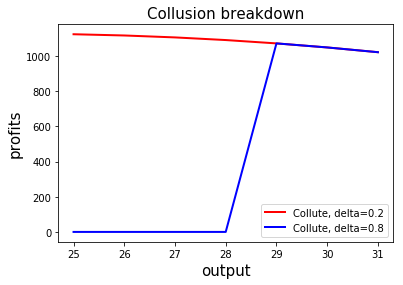

In [14]:
def collusion_profits(x,b,c,F,delta): # we only do this for the symmetric case: c1 = c2 = c
    profits = profit(x,x,b,c[0],F[0])
    nash_eq = optimize.fsolve(vector_BRi, [1,1], args = (b,c,F))
    if profits >= (1-delta)*profit(BRi(x,b,c[0],F[0]),x,b,c[0],F[0])+delta*profit(nash_eq[0],nash_eq[1],b,c[0],F[0]):
        industry_profits = profits # profits can be sustained as collusion profits
    else:
        industry_profits = 0 # profits cannot be sustained as collusion profits
    return industry_profits

#PARAMETERS - CHANGE HERE!
c1 = 5
c2 = c1
F1 = 2
F2 = F1
b = 1

# COMPACT PARAMETERS
c = [c1, c2]
F = [F1, F2]

range_x = arange(25,32,1) #Start, end and step-size in graph
delta1 = 0.8
delta2 = 0.2
range_profits = [collusion_profits(x,b,c,F,delta1) for x in range_x]
range_profits2 = [collusion_profits(x,b,c,F,delta2) for x in range_x]

#print(range_x)         #Bare checks. Skal slettes.
#print(range_profits)   #Bare checks. Skal slettes.
#print(range_profits2)  #Bare checks. Skal slettes.
#print(non_collute)     #Bare checks. Skal slettes.

plt.clf()
plt.plot(range_x, range_profits,'-', color = 'r', linewidth = 2, label="Collute, delta=0.2")
plt.plot(range_x, range_profits2,'-', color = 'b', linewidth = 2, label="Collute, delta=0.8")
plt.title("Collusion breakdown",fontsize = 15)
plt.xlabel("output",fontsize = 15)
plt.ylabel("profits",fontsize = 15,rotation = 90)
plt.legend()

When there is no chance of collusion we set the result to zero in order to illustrate that the result will be the nash equilibrium and not the collusion output. This will be clear in the following code: